In [9]:
from IPython.display import Image
from IPython.core.display import HTML 

# (Very) Basics of imaging with CASA

This tutorial will guide you through the basic steps of imaging your data. The Measurement Set (MS) we provide you with, `J17591_calibrated.ms`, has been previously flagged and calibrated for you.

*Imaging* is the process of transforming the complex visibilities stored in your MS into (idealy) an image one would see looking up at the sky if they had eyes which could see radio-frequency light. There are two main operations involved in this process: **Fourier Inversion** and **Deconvolution**. As you probably know by now, the visibilities are roughly a sample of the 2D spatial Fourier transform of the portion of the sky that was observed. Therefore, we intuitively understand that we need to inverse Fourier transform our data to try and recover the original sky brightness distribution. Ok then let's do this first and see what we get. 

## The dirty image

CASA should be opened already if not start it by typing `casa` at the prompt

If you haven't noticed already, CASA spawn a separate logger window, which logs messages from various tasks.

![The CASA logger](Logger.png)

Look at it when running a task to see what it is doing. Logger messages are saved in a file 'casapy.log', in your local directory. Whenever you start CASA, the previous log is renamed (based on the date and time), and a new 'casapy.log' is opened. 

There are two basic ways to execute a task in CASA. The first is to list the task parameters and set them one by one, the second is to set the parameters and execute the task, all in one go using a single command line. We will use this second option for simplicity.

Let's now make this first image by simply fourier transforming the visibilities. We call this image the *dirty* image. We will use the task `tclean` for this (and the rest). Copy/paste the following and press enter to start the task:

In [ ]:
tclean(vis='J17591_calibrated.ms', imagename='J17591.dirty', 
      imsize=8192, cell='1.5arcsec', pblimit=-0.2, niter=0, weighting='briggs')

- `imagename='J17591.dirty'`: the root filename used for the various tclean outputs.  
- `imsize=8192`: the image size in number of pixels. A single value will result in a square image.
- `cell='1.5arcsec'`: the size of one pixel; again, entering a single value will result in a square pixel size. It is recommanded to choose a pixel size of ~1/5 of the angular resolution. 
- `pblimit=-0.2`: This is to avoid some primary beam correction on the image but we won't detail this here.
- `niter=0`: this controls the number of iterations done in the minor cycle (deconvolution see below). 0 indicates no deconvolution.
- `weighting='briggs'`: This controls the way the visibilities are weighted. We will come back on this later.

### Output of tclean

`tclean` creates a number of output images:

- `<imagename>.psf`: the point-spread function (a.k.a the dirty beam)
- `<imagename>.pb`: the normalized sensitivity map, which corresponds to the primary beam in the case of a single-pointing image
- `<imagename>.image`: This is the final image

Additional images will be created when deconvolution will be performed.  
Let's now look at our dirty image:

In [ ]:
viewer('J17591.dirty.image')

To change the color scheme, click on "Data Display Options" (wrench icon, upper left corner) within the viewer:

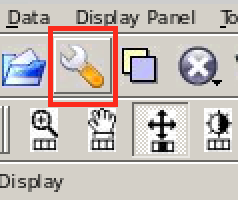

In [10]:
Image('data_display.png', width=100)

and change the color map to e.g. "Hot Metal 2". You may also wish to change the scaling power options to your liking (e.g., -1.2):

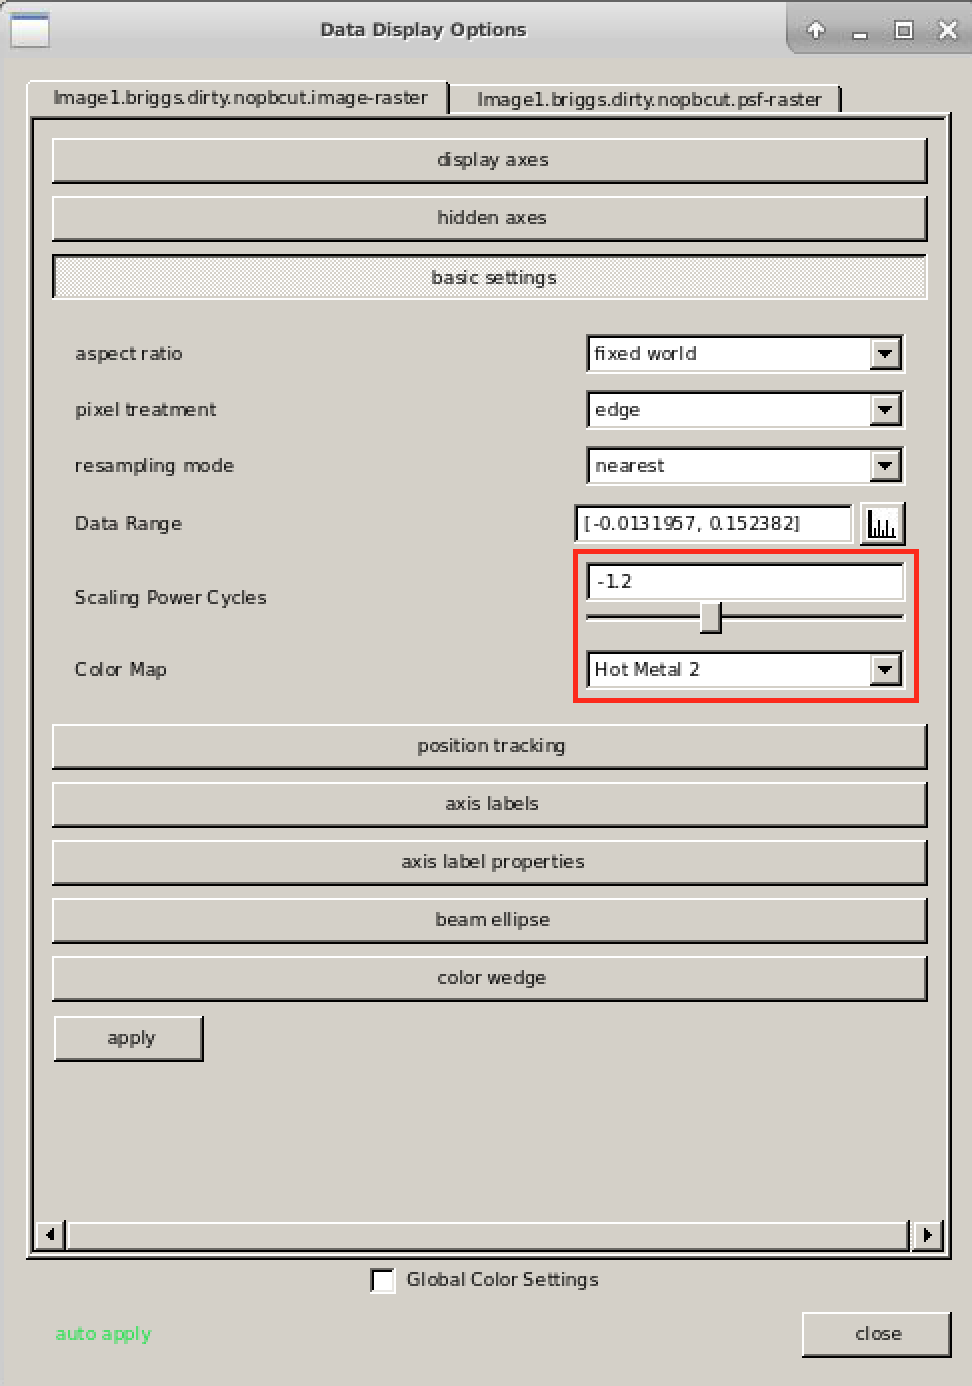

In [14]:
Image('data_display2.png', width=300)

To change the brightness and contrast, assign a mouse button to this type of editing by clicking on the "Colormap fiddling" icon (black/white circle), and click/drag the mouse over the image to change the brightness (left-right mouse movement) and contrast (up-down mouse movement).

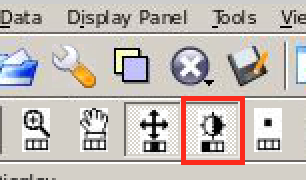

In [15]:
Image('contrast.png', width=100)

From the viewer, click on "Open data" (the blue folder icon), select the psf image `J17591.dirty.psf` and click on "raster image". 
On the dirty image, if you zoom in and look at some of the point sources you will see sidelobes and radial artefacts due to the PSF (look at the PSF image to convince yourself). The dirty image is not scientifically usable, we need to remove this artefacts as much as possible, i.e., we need to **deconvolve** the PSF from the image.
![Data vs psf](dirty_vs_psf.png)

## Deconvolution and the CLEAN algorithm

The CLEAN algorithm, developed by J. Högbom (1974), breaks the imaging process into major and minor cycles (see Figure 1). To start with, the visibilities are weighted and Fourier transformed to create the dirty image. The minor cycles then operate in the image domain. It looks for the brightest point source in the image, substract a suitably scaled and centered PSF from it. A model component corresponding to this source is then added to the model image and the process is repeated on the next bright point and continue until a stopping criterion is reached, such as a maximum number of iteration or a flux threshold in the residual image. The model image is then Fourier transformed back to the visibility domain and subtracted from the visibilities. This creates a new residual that is then weighted and FT'ed again to the image domain for the next iteration. The FT, subtraction and iFT processes form a major cycle.

In CASA tclean, two versions of the PSF can be used: setting deconvolver='hogbom' uses the full-sized PSF for subtraction. This is a thorough but slow method. All other options use a smaller PSF patch, which increases the speed. The patch size and length of the minor cycle are internally chosen such that clean converges well without giving up the speed improvement.
In a final step called *restoration*, tclean derives a Gaussian fit to the inner part (the main lobe) of the PSF, which defines the clean beam. The model is then convolved with the clean beam and added to the last residual image to create the final image.

Now, we will create a regular clean image using mostly default values to see how deconvolution improves the image quality. We will use a fixed number of minor cycle iterations of niter=1000

In [ ]:
tclean(vis='J17591_calibrated.ms', imagename='J17591.clean.niter1K', 
      imsize=8192, cell='1.5arcsec', pblimit=-0.2, niter=1000, weighting='briggs')

`savemodel='modelcolumn'`: controls writing the model visibilities to the model data column. For self-calibration we currently recommend setting savemodel='modelcolumn'. The default value is "none": so, this must be changed for the model to be saved.

New images have been produced besides the .psf, .image and .pb:

- `<imagename>.model`: the clean model (unit: Jy/pixel)
- `<imagename>.residual`: the residual after subtracting the clean model (unit: Jy/beam, where beam refers to the dirty beam)
- Note that the `<imagename>.image` is now the residual + the model convolved with the clean beam; this is still the final image (unit: Jy/beam, where beam refers to the clean beam)

In [ ]:
viewer('J17591.clean.niter1K.image')

Compare the clean image with the dirty image. You can see the effect of deconvolution.

![Clean vs dirty](clean_vs_dirty.png)

Now inspect your clean image for remaining sidelobes and load the residual image `J17591.clean.niter1K.residual` and check if it still contains source flux and structures. Start again with a higher number of iterations if necessary. Note that if you run tclean again with the same `imagename`, tclean will use that image (in particular the residual and model image) as a starting point for further cleaning so you do not have to start from scratch again.  

Take care that if you increase the number of iteration too much, tclean will start cleaning the noise. To avoid cleaning too deeply, we can set a threshold parameter that will stop minor cycle iterations once a peak residual value is being reached.

Let's use  `J17591.clean.niter1K.image` to give us an idea of the rms noise. With the image open within the viewer, click on the 'Rectangle Drawing' button (Rectangle with R) and draw a square on the image at a position with little source or sidelobe contamination. Doing this should open up a "Regions" dock on the right, which holds information about the selected region, including the pixel statistics in the "Statistics" tab. Take notice of the rms values as you click/drag the box around empty image locations, or by drawing additional boxes at suitable positions.

![rms](rms.png)

The lowest rms value we found was in the order of about 0.7 mJy/beam. So we can set a $3 \sigma$ threshold of 2 mJy. Therefore, for future calls to the tclean task, we will set `threshold='2mJy'`. The clean cycle will be stopped when the residual peak flux density is equals to or less than the threshold value, or when the maximum number of iterations niter is reached. To ensure that the stopping criterion is indeed threshold, niter should be set to a very high number. In the following, we nevertheless will use niter=1000 to keep the execution times of tclean on the low end as we focus on explaining different imaging methods.

## Weighting

Weighting amounts to giving more or less weight to certain visibilities in your data set, based on their location in the uv-plane. Emphasizing long-baseline visibilities improves the resolution of your image, whereas emphasizing shorter baselines improves the surface brightness sensitivity. There are three main weighting schemes that are used in interferometry:
- **Natural weighting**: uv cells are weighted based on their rms. Data visibility weights are gridded onto a uv-cell and summed. More visibilities in a cell will thus increase the cell's weight, which will usually emphasize the shorter baselines. Natural weighting therefore results in a better surface brightness sensitivity, but also a larger PSF and therefore degraded resolution.
- **Uniform weighting**: The weights are first gridded as in natural weighting but then each cell is corrected such that the weights are independent of the number of visibilities inside. The 'uniform' weighting of the baselines is a better representation of the uv-coverage and sidelobes are more suppressed. Compared to natural weighting, uniform weighting usually emphasizes the longer baselines. Consequently the PSF is smaller, resulting in a better spatial resolution of the image. At the same time, however, the surface brightness sensitivity is reduced compared to natural weighting.
- **Briggs weighting**: This scheme provides a compromise between natural and uniform weighting. The transition can be controlled with the robust parameter where robust=-2 is close to uniform and robust=2 is close to natural weighting. Briggs weighting therefore offers a compromise for between spatial resolution and surface brightness sensitivity. Typically, robust values near zero are used.

We have used Briggs weighting with robust=0.5 (the default) so far so let's see the effect natural and uniform weightings. If you have time you can also try briggs with another robust value e.g 0.0 or -0.5

In [ ]:
# Natural
tclean(vis='J17591_calibrated.ms', imagename='J17591.natural', weighting='natural',
      imsize=8192, cell='1.5arcsec', pblimit=-0.2, niter=1000, threshold='2mJy')

In [ ]:
# Uniform
tclean(vis='J17591_calibrated.ms', imagename='J17591.uniform', weighting='uniform',
      imsize=8192, cell='1.5arcsec', pblimit=-0.2, niter=1000, threshold='2mJy')

In [ ]:
# Briggs with robust=-0.5
tclean(vis='J17591_calibrated.ms', imagename='J17591.briggs', weighting='briggs', 
       robust=-0.5, imsize=8192, cell='1.5arcsec', pblimit=-0.2, niter=1000, threshold='2mJy')

## Playing with uvrange

The `uvrange` parameter in `tclean` allows you to control the range of uv-distance that will be used to produce the image. In a nutshell, short uv-distances correspond to large scale emission and long uv-distances to the most compact emission. It is sometimes needed to filter out structures to reduce noise and artefacts and/or to focus on specific science objectives.
`uvrange` is usually expressed in units of the observing wavelenght. To keep only visibilities above a uv-distance of 500$\lambda$ (i.e. 0.5 kilolambda) then do:

In [ ]:
tclean(vis='J17591_calibrated.ms', imagename='J17591.briggs.gt.500lambda', weighting='briggs',
       imsize=8192, cell='1.5arcsec', pblimit=-0.2, niter=1000, threshold='2mJy',
       uvrange='> 0.5klambda')

Comparing this new image with the initial `'J17591.clean.niter1K'` you can see the supression of the extended emission.
![uvcut](uvcut.png)